In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
!nvidia-smi -L

GPU 0: Tesla K40m (UUID: GPU-ddd2ac68-7b89-4f82-c957-312a06998eee)
GPU 1: Tesla K40m (UUID: GPU-8ed7212a-3ea0-1837-247e-a085f1ad1c47)


In [5]:
data_folder = '../CAN-FD_Intrusion_Dataset/'
print(os.listdir(data_folder))

['CANFD_Malfunction.csv', 'CAN-FD_dataset.ipynb', 'CANFD_Fuzzing.csv', 'README.txt', '.ipynb_checkpoints', 'CAN-FD-trained.ipynb', 'CANFD_Flooding.csv']


In [6]:
## Reading individual datasets
malfunction_path = os.path.join(data_folder, 'CANFD_Malfunction.csv')
fuzzing_path = os.path.join(data_folder,'CANFD_Fuzzing.csv')
flooding_path = os.path.join(data_folder, 'CANFD_Flooding.csv')

In [5]:
# Timestamp: record time 
# Arbitration ID: identifier of CAN message in HEX (ex. 043f) 
# DLC: number of data bytes, from 0 to 64 
# Data[0] ~ Data[64]: data value (byte) 
# Label

In [8]:
hex_to_dec = lambda x: int(x, 16)

In [9]:
def read_data(data_path):
    
    ## Specifying columns in our dataset
    
    ##Data0 -> Data31
    data_cols = ['data' + str(x) for x in range(0,32)]

    columns = ['Timestamp', 'CAN_ID', 'DLC']
    columns.extend(data_cols)
    columns.append('Label')
    
    ##Specifying all columns to be of str datatype to ease conversion
    dtype_dict = {col: str for col in data_cols}
    
    print("READING CSV")
    
    data = pd.read_csv(data_path, names = columns, dtype = dtype_dict)
    
    data[data_cols] = data[data_cols].astype(str)
    
    ## Column shifting is a computationally heavy task, keep in mind if running the code
    print("SHIFTING COLUMNS")
    
    temp_cols = data.iloc[:,:4]
    
    data = data.apply(lambda row: row.iloc[3:].shift(32 - row['DLC'], fill_value = '00'), axis=1)
    
    data = pd.concat([temp_cols, data], axis=1)
    
    print("CREATING DATA COLUMN")
    
    data['data'] = data[data_cols].astype(str).apply(''.join, axis=1)
    
    print("CONVERTING TO HEXADECIMAL")
    
    data['CAN_ID'] = data['CAN_ID'].apply(hex_to_dec)
    data['data'] = data['data'].apply(hex_to_dec)
    
    data.drop(data_cols, inplace = True, axis = 1)
    
    return data

In [10]:
print("Reading Malfunction Data")
malfunction_data = read_data(malfunction_path)

print("Reading Fuzzing Data")
fuzzy_data = read_data(fuzzing_path)

print("Reading Flooding Data")
flooding_data = read_data(flooding_path)

Reading Malfunction Data
READING CSV
SHIFTING COLUMNS
CREATING DATA COLUMN
CONVERTING TO HEXADECIMAL
Reading Fuzzing Data
READING CSV
SHIFTING COLUMNS
CREATING DATA COLUMN
CONVERTING TO HEXADECIMAL
Reading Flooding Data
READING CSV
SHIFTING COLUMNS
CREATING DATA COLUMN
CONVERTING TO HEXADECIMAL


In [14]:
## LABELS

## Normal -> 0 
## Malfunction -> 1
## Fuzzing -> 2
## Flooding -> 3

In [11]:
malfunction_data['Label'].replace({'T' : 1, 'R' : 0}, inplace = True)
fuzzy_data['Label'].replace({'T' : 2, 'R' : 0}, inplace = True)
flooding_data['Label'].replace({'T' : 3, 'R' : 0}, inplace = True)

In [12]:
##Merging datasets
merged_df = pd.concat([malfunction_data, fuzzy_data, flooding_data], join = 'inner', ignore_index=True)
merged_df.sort_values(by = ['Timestamp'], inplace = True)

##Removing duplicates
merged_df.drop_duplicates(inplace = True)

##Creating IAT feature column
merged_df = merged_df.assign(IAT=merged_df['Timestamp'].diff().fillna(0))
merged_df.drop(columns = ['Timestamp'], inplace = True)

In [13]:
merged_df.head()

,CAN_ID,DLC,Label,data,IAT
4336291,160,24,0,1030549594212114139270000041241972001156878436...,0.00000
4336292,234,24,0,2188470486585276093505955186241303081555994448...,0.00136
4336293,122,24,0,6947525354238971725415747244068607354311259469...,0.00057
4336294,165,24,0,1331609026229136247371348718113494757862107324...,0.00018
4336295,293,16,0,2883223022009173266046917526716328905546455741...,0.00015


In [14]:
merged_df['Label'].value_counts()

0    5490129
3     988241
2     506506
1     135726
Name: Label, dtype: int64

In [15]:
X = merged_df[['CAN_ID', 'DLC', 'data', 'IAT']]
y = merged_df['Label']

In [16]:
## Function to create sequences for datapoints for LSTM model
def sequencify(dataset, target, start, end, window):
  
    X = []
    y = []
    
    start = start + window 
    if end is None:
        end = len(dataset)
        
    for i in tqdm(range(start, end+1)):
        indices = range(i-window, i) 
        X.append(dataset[indices])
        
        indicey = i -1
        y.append(target[indicey])
			
    return np.array(X), np.array(y)

In [17]:
X_seq, y_seq = sequencify(X.values, y.values, start = 0, end = None, window = 10)

100%|██████████| 7120593/7120593 [01:40<00:00, 71089.73it/s]


In [16]:
#Train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, 
                                                    test_size = 0.3, stratify = y_seq)


#Data Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mean = np.mean(X_train_seq.astype(np.float64),axis=0)
std = np.std(X_train_seq.astype(np.float64), axis=0)

X_train_seq -= mean
X_train_seq /= std
X_test_seq -= mean
X_test_seq /= std

In [17]:
y_train = y_train.values
y_test = y_test.values

In [20]:
strategy = tf.distribute.MirroredStrategy()

In [21]:
batch_size = 512 * strategy.num_replicas_in_sync

In [22]:
##MLP

print("-----MLP-------")

with strategy.scope():
    mlp = Sequential()
    mlp.add(Input(shape = (4)))
    mlp.add(Dense(128, activation = 'relu'))
    mlp.add(Dense(128, activation = 'relu'))
    mlp.add(Dense(4))

    mlp.compile(optimizer='adam',
                    loss=SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

    mlp_hist = mlp.fit(X_train, y_train, epochs=100, callbacks = [es], validation_split=0.2, batch_size = batch_size)

##MLP
print("-----MLP-------")

mlp_preds = mlp.predict(X_test)
mlp_preds = mlp_preds.argmax(axis = 1)

print("ACCURACY: ", accuracy_score(y_test, mlp_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, mlp_preds))

-----MLP-------
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Train on 3987536 samples, validate on 996885 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU

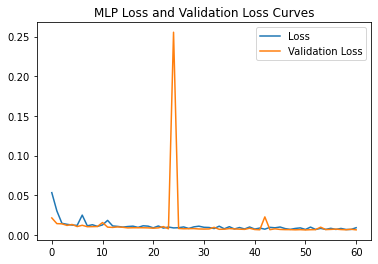

In [23]:
plt.plot(mlp_hist.history['loss'], label = 'Loss')
plt.plot(mlp_hist.history['val_loss'], label = 'Validation Loss')
plt.title('MLP Loss and Validation Loss Curves')

plt.legend(loc = 'best')
plt.show()

In [24]:
X_train_seq = X_train_seq.astype(np.float64)
X_test_seq = X_test_seq.astype(np.float64)

In [25]:
##LSTM

print("-----LSTM-------")


with strategy.scope():
    lstm = Sequential()

    lstm.add(Input(shape = X_train_seq.shape[1:]))
    lstm.add(LSTM(128, activation = 'relu'))
    lstm.add(Dense(4, activation = 'softmax'))

    lstm.compile(
        loss = SparseCategoricalCrossentropy(from_logits = False),
        optimizer = Adam(learning_rate = 0.001),
        metrics = ['accuracy'])

    es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

    lstm_hist = lstm.fit(X_train_seq, y_train_seq, batch_size = batch_size, validation_split = 0.2,
            callbacks = [es], epochs = 1000)

print("-----LSTM-------")

lstm_preds = lstm.predict(X_test_seq, batch_size = batch_size)
lstm_preds = lstm_preds.argmax(axis = 1)

print("ACCURACY: ", accuracy_score(y_test_seq, lstm_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test_seq, lstm_preds))

-----LSTM-------
Train on 3987532 samples, validate on 996883 samples
Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
3987532/3987532 [==============================] - 97s 24us/sample - loss: 0.0667 - accuracy: 0.9757 - val_loss: 0.0355 - val_accuracy: 0.9862
Epoch 2/1000
3987532/3987532 [==============================] - 88s 22us/sample - loss: 0.0315 - accuracy: 0.9882 - val_loss: 0.0280 - val_accuracy: 0.9900
Epoch 3/1000
3987532/3987532 [==============================] - 87s 22us/sample - loss: 0.0266 - accuracy: 0.9901 - val_loss: 0.0258 - val_accuracy: 0.9901
Epoch 4/1000
3987532/3987532 [==============================] - 89s 22us/sample - loss: 0.0235 - accuracy: 0.9912 - val_loss: 0.0266 - val_accuracy: 0.9911
Epoc

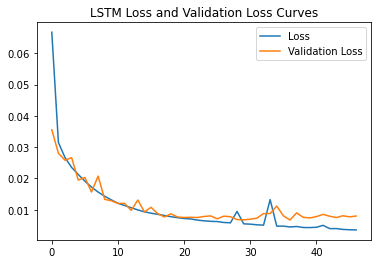

In [26]:
plt.plot(lstm_hist.history['loss'], label = 'Loss')
plt.plot(lstm_hist.history['val_loss'], label = 'Validation Loss')
plt.title('LSTM Loss and Validation Loss Curves')

plt.legend(loc = 'best')
plt.show()

In [18]:
## XGBOOST

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("-------XGBOOST-------")
print("ACCURACY: ", accuracy_score(y_test, xgb_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, xgb_preds))

-------XGBOOST-------
ACCURACY:  0.9999171418526801
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1647254
           1       1.00      1.00      1.00     40724
           2       1.00      1.00      1.00    152080
           3       1.00      1.00      1.00    296123

    accuracy                           1.00   2136181
   macro avg       1.00      1.00      1.00   2136181
weighted avg       1.00      1.00      1.00   2136181



In [27]:
## DECISION TREE

dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print("-------DECISION TREE--------")
print("ACCURACY: ", accuracy_score(y_test, dt_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, dt_preds))


## RANDOM FOREST

rf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("-------RANDOM FOREST-------")
print("ACCURACY: ", accuracy_score(y_test, rf_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, rf_preds))

-------DECISION TREE--------
ACCURACY:  0.9964511434190267
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1646884
           1       0.90      1.00      0.95     40854
           2       1.00      0.98      0.99    151819
           3       1.00      1.00      1.00    296624

    accuracy                           1.00   2136181
   macro avg       0.97      0.99      0.98   2136181
weighted avg       1.00      1.00      1.00   2136181

-------RANDOM FOREST-------
ACCURACY:  0.9794685000943272


/home/apps/anaconda3_2018/4.6.9/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99   1646884
           1       0.00      0.00      0.00     40854
           2       1.00      0.98      0.99    151819
           3       1.00      1.00      1.00    296624

    accuracy                           0.98   2136181
   macro avg       0.74      0.75      0.74   2136181
weighted avg       0.96      0.98      0.97   2136181

